In [58]:
# Bibliotecas y dependencias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import requests

from datetime import datetime
from io import StringIO


%matplotlib inline

### Funcionalidades

In [59]:
def date_to_unix(date_string:str)-> tuple:

    dt = datetime.strptime(date_string, "%Y-%m-%d")
    unix_time = int(time.mktime(dt.timetuple()))
    return unix_time

def get_historic_prices(stock:str = 'MSFT',
                        interval:str = '1d', 
                        start_date:str = '2023-06-23', 
                        end_date:str = '2024-06-23',
                        save_csv:bool = False,
                        retries:int = 5,
                        delay:int = 2) -> pd.DataFrame:
    #convert dates into unix format
    start_unix = date_to_unix(start_date)
    end_unix = date_to_unix(end_date)

    
    #Yahoo URL
    URL = f'https://query1.finance.yahoo.com/v7/finance/download/{stock}?period1={start_unix}&period2={end_unix}&interval={interval}&events=history'
    print(URL)

    for attempt in range(retries):
        response = requests.get(URL)
        print(f"Attempt {attempt + 1}: Status code {response.status_code}")
        print(response.status_code)
        if response.status_code == 200:
            if save_csv:
                with open(f'{stock}_prices.csv', 'wb') as file:
                    file.write(response.content)
            else:
                data = StringIO(response.text)
                df = pd.read_csv(data)
                return df
        elif response.status_code == 429:
            print("Too many requests. Retrying...")
            time.sleep(delay)
        else:
            print(f"Error al descargar los datos: {response.status_code}")
            break  # Romper el bucle si se produce otro error que no sea 429
    return pd.DataFrame()


def return_calculation(close_price:pd.Series)->pd.Series:
    log_returns = np.log(close_price / close_price.shift(1))
    return log_returns

def simulate_portfolios(num_portfolios, returns_df):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    np.random.seed(42)  # Para reproducibilidad

    for i in range(num_portfolios):
        weights = np.random.random(len(returns_df.columns))
        weights /= np.sum(weights)
        weights_record.append(weights)

        portfolio_return = np.sum(weights * returns_df.mean()) * 252
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(returns_df.cov() * 252, weights)))

        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        results[2,i] = results[0,i] / results[1,i]

    return results, weights_record

def plot_efficient_frontier(results):
    # max_sharpe_idx = np.argmax(results[2])
    # sdp, rp = results[1, max_sharpe_idx], results[0, max_sharpe_idx]

    min_vol_idx = np.argmin(results[1])
    sdp_min, rp_min = results[1, min_vol_idx], results[0, min_vol_idx]

    plt.figure(figsize=(10, 7))
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o')
    # plt.scatter(sdp, rp, marker='*', color='r', s=100, label='Máxima Sharpe Ratio')
    plt.scatter(sdp_min, rp_min, marker='*', color='b', s=100, label='Riesgo Mínimo')
    plt.title('Frontera Eficiente')
    plt.xlabel('Riesgo (Desviación Estándar)')
    plt.ylabel('Retorno')
    plt.colorbar(label='Frontera de Markowitz')
    plt.legend()
    plt.show()



### Carga de pecios de activos

In [50]:
GOOG_df = pd.read_csv('GOOG.csv', sep=',')[['Date','Adj Close']]
IBM_df = pd.read_csv('IBM.csv', sep=',')[['Date','Adj Close']]
NVDA_df = pd.read_csv('NVDA.csv', sep=',')[['Date','Adj Close']]

GOOG_df['Date'] = pd.to_datetime(GOOG_df['Date'])
IBM_df['Date'] = pd.to_datetime(IBM_df['Date'])
NVDA_df['Date'] = pd.to_datetime(NVDA_df['Date'])


$$
\begin{aligned}
&\left\{
\begin{aligned}
&\text{min } \sigma^2 = \sum_{i,j=1}^{n} c_{ij} w_i w_j = w C w^T \\
&\sum_{i=1}^{n} \mu_i w_i = m w^T = \mu \\
&\sum_{i=1}^{n} w_i = \mathbf{1} w^T = 1
\end{aligned}
\right.
\end{aligned}
$$

Dado que el problema no especifica un rendimiento esperado, podemos usar unicamente la restricción de sumatoria ponderada de los pesos que debe ser igual a 1. Por tanto:

$$
\begin{aligned}
&\left\{
\begin{aligned}
&\text{min } \sigma^2 = \sum_{i,j=1}^{n} c_{ij} w_i w_j = w C w^T \\
&\sum_{i=1}^{n} w_i = \mathbf{1} w^T = 1
\end{aligned}
\right.
\end{aligned}
$$

### Matriz de Varianza-Covarianzas

In [61]:
GOOG_R = return_calculation(GOOG_df['Adj Close'])
IBM_R = return_calculation(IBM_df['Adj Close'])
NVDA_R = return_calculation(NVDA_df['Adj Close'])
returns_df = pd.DataFrame({'GOOG':GOOG_R,
                          'IBM':IBM_R,
                          'NVDA':NVDA_R})
returns_df = returns_df.dropna()
C = returns_df.cov()
C

,GOOG,IBM,NVDA
GOOG,0.000306,0.000026,0.000174
IBM,0.000026,0.000164,0.000045
NVDA,0.000174,0.000045,0.000765


Así, el vector de pesos viene dado por:

$$
w^* = \frac{\mathbf{1} C^{-1}}{\mathbf{1} C^{-1} \mathbf{1}^T}
$$

El riesgo mínimo:

$$
\sigma_{\text{mín}}^2 = w^* C w^{*T}
$$

Y el rendimiento de la inversión:

$$
\mu^* = m w^{*T}
$$


### Matriz de Pesos

In [52]:
vector_ones = np.ones(len(C))
C_inv = np.linalg.inv(C)
N = vector_ones.dot(C_inv)
M = N.dot(vector_ones.T)
w = N / M
w

array([0.29994996, 0.65358795, 0.04646209])

### Riesgo Mínimo

In [53]:
wC = w.dot(C)
sigma = round(wC.dot(w.T),6)

print(f'El mínimo riesgo de la cartera es: {sigma*100}%')

El mínimo riesgo de la cartera es: 0.0117%


### Rendimiento Esperado:

In [54]:
expected_returns = returns_df.mean()
expected_returns = expected_returns.to_numpy()


#Rendimiento total de la cartera
mu_portfolio = round(expected_returns.dot(w.T), 6)
print(f'El rendimiento total de la cartera es: {mu_portfolio*100}%')

El rendimiento total de la cartera es: 0.1523%


### Frontrera de Markowitz

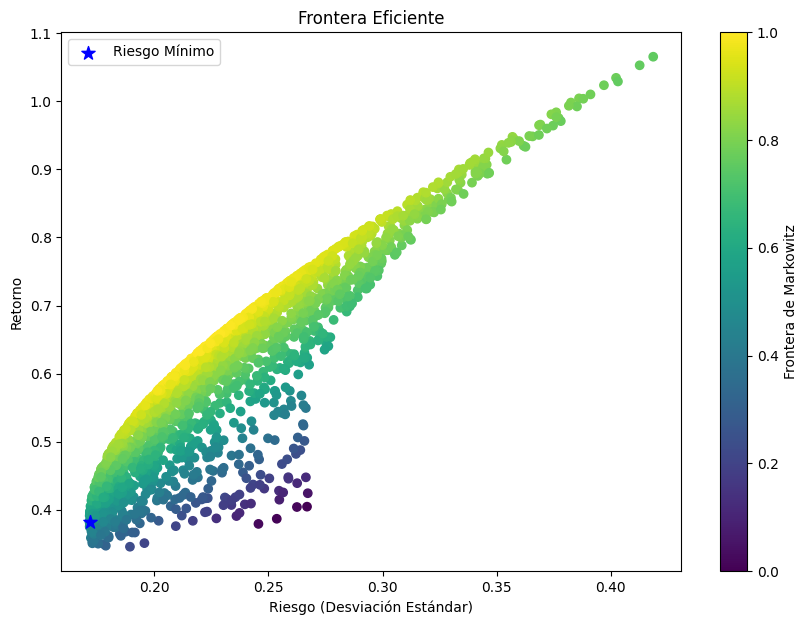

In [64]:
# Simulación de portafolios (Montecarlo)
num_portfolios = 2000
results_markow, weights_record = simulate_portfolios(num_portfolios, returns_df)

# Frontera Markowitz
plot_efficient_frontier(results_markow)